In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


### Masked

In [2]:
loader_path = "./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt"
model       = torch.load(
                   "./results/trained_models/Masked_Phe/Model_GIN_classifier_to_explain_v2_16-11-2022_16h_40min_best_ValAcc_0.8775340183282422_epoch_28.pt")

loader = torch.load(loader_path).get_test_loader()







In [3]:

explainer    = GNNExplainer(model, epochs=1000, num_hops = None, lr=0.01).to(device, non_blocking=True)
model.to(device, non_blocking=True)


model.eval()
gc.collect()
torch.cuda.empty_cache() 
edge_num           = loader.dataset[0].edge_index.shape[1]
all_graphs_weights = []#torch.empty(edge_num,1).to(device)

for graph in loader.dataset:
    _, edge_weights =  explainer.explain_graph(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True))
    
    all_graphs_weights.append(edge_weights.reshape(edge_num,1))

Explain graph: 100%|██████████| 1000/1000 [00:01<00:00, 601.02it/s]


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

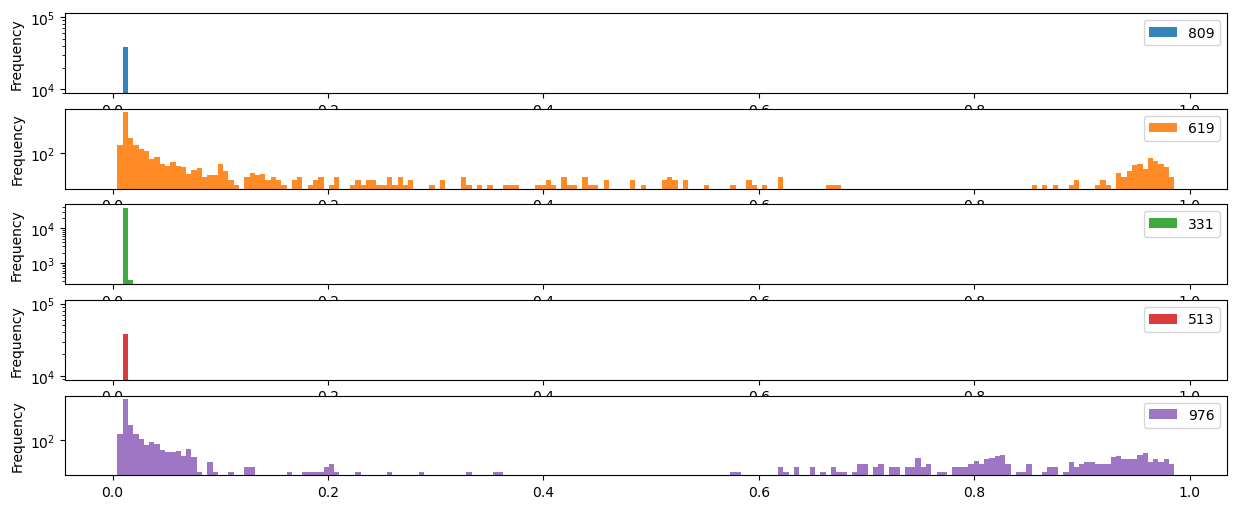

In [4]:
import numpy as np
all_graphs_weights_df = pd.DataFrame(
torch.stack(all_graphs_weights,1).squeeze().cpu().numpy())



all_graphs_weights_df.loc[:,np.random.randint(1, 1000, 5)].plot.hist(bins=200, alpha=0.9, figsize=(15,6), subplots=True, sharey=False, 
                      sharex=False, logy = True, ylabel = ['', '', ''], grid=False)


In [6]:
train_labels = []
for graph in tqdm.tqdm(loader.dataset):
    train_labels.append(graph.y.cpu().item())
assert train_labels.__len__() == all_graphs_weights_df.shape[1]
#all_graphs_weights.shape

labels =  ["PKU" if l == 0 else "Control" for l in train_labels] 
labels
pd.Series(labels).to_csv("./results/dataframes/Masked_test_labels.csv")

all_graphs_weights_df.columns = [str(col) for col in all_graphs_weights_df.columns]
print(f"{all_graphs_weights_df.shape=}")
all_graphs_weights_df.to_parquet('./results/dataframes/Masked_graphs_weights_from_explainer.parquet.gzip', compression = 'gzip')

100%|██████████| 2401/2401 [00:00<00:00, 605127.02it/s]


all_graphs_weights_df.shape=(38428, 2401)


### Process explainer weights

((385, 2401), (38428,))

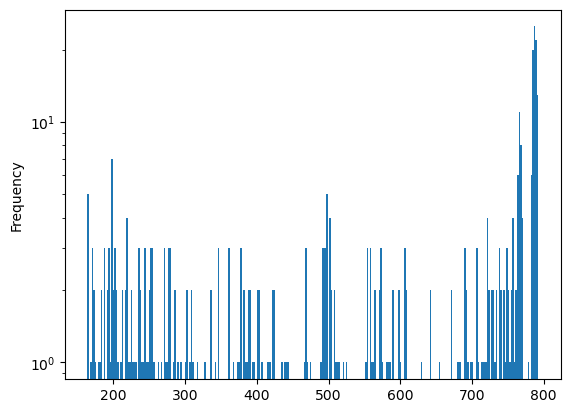

In [7]:
edge_mask = all_graphs_weights_df.sum(axis=1) > np.percentile(all_graphs_weights_df.sum(axis=1), 99)


filtered_graph_weights_df = all_graphs_weights_df.loc[  edge_mask, :]

filtered_graph_weights_df.sum(axis=1).plot.hist(logy = True, bins=300)
filtered_graph_weights_df.shape, edge_mask.shape

<AxesSubplot:ylabel='Frequency'>

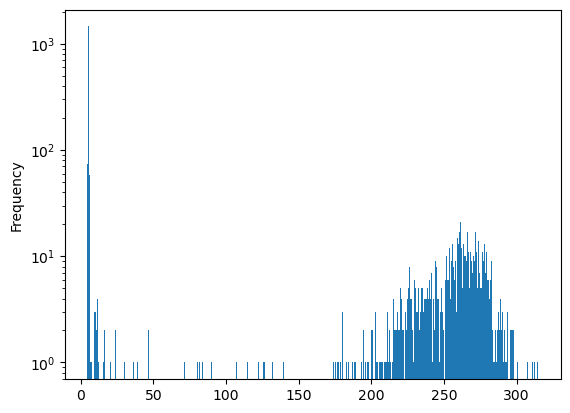

In [8]:
filtered_graph_weights_df.sum(axis=0).plot.hist(logy = True, bins=500)


In [9]:
filtered_graph_weights = filtered_graph_weights_df.transpose() 
filtered_graph_weights["Label"] = list(labels)

filtered_graph_weights.reset_index(drop=True, inplace=True)
filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
filtered_graph_weights

,983,2956,2957,2958,2959,2960,2961,2962,2964,2965,...,36547,36550,37878,37881,37882,37886,37888,38277,38278,Label
0,0.013986,0.013826,0.013798,0.013698,0.013740,0.013719,0.013862,0.013841,0.013721,0.013633,...,0.013860,0.013920,0.013740,0.013867,0.013770,0.013676,0.013855,0.013821,0.013728,PKU
1,0.014022,0.013794,0.013726,0.013856,0.013901,0.013883,0.013832,0.013780,0.013714,0.013806,...,0.013766,0.013997,0.013817,0.013809,0.013863,0.013835,0.014011,0.013872,0.013806,PKU
2,0.335903,0.030831,0.063971,0.025545,0.111594,0.033336,0.022656,0.032526,0.055197,0.066723,...,0.971204,0.094011,0.950974,0.208336,0.969803,0.970655,0.079587,0.384130,0.036792,Control
3,0.412890,0.973607,0.974602,0.973813,0.976186,0.971980,0.949559,0.967543,0.975335,0.975159,...,0.970761,0.195480,0.953956,0.289680,0.970330,0.970719,0.178400,0.061179,0.030779,Control
4,0.014093,0.013727,0.013657,0.013630,0.013829,0.013814,0.013831,0.013763,0.013721,0.013671,...,0.013751,0.013792,0.013735,0.013757,0.013878,0.013793,0.013742,0.013834,0.013696,PKU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,0.177758,0.961536,0.961938,0.961414,0.962095,0.963329,0.963189,0.965022,0.961471,0.962449,...,0.975276,0.397605,0.960824,0.013687,0.974499,0.975261,0.407854,0.889332,0.784768,Control
2397,0.014200,0.013706,0.013751,0.013788,0.013818,0.013730,0.013735,0.013642,0.013686,0.013698,...,0.013758,0.013868,0.013830,0.013759,0.013719,0.013805,0.013815,0.013830,0.013721,PKU
2398,0.014063,0.013848,0.013800,0.013919,0.013711,0.013707,0.013675,0.013686,0.013735,0.013786,...,0.013988,0.014092,0.013767,0.013847,0.013896,0.014141,0.013984,0.013687,0.013698,Control
2399,0.021424,0.014690,0.014694,0.014692,0.014456,0.014513,0.014624,0.014505,0.014597,0.014597,...,0.013574,0.014315,0.013504,0.013775,0.013466,0.013396,0.014297,0.014183,0.014363,PKU


In [10]:
PYG_graph = torch.load("./results/graphs/PYG_graph_Concen_plus_Fluxes.pt")
NX_graph  = nx.read_gpickle("./results/graphs/NX_graph_Concen_plus_Fluxes.gpickle")
edge_0_node_idxs =  PYG_graph.edge_index[0,:]
edge_1_node_idxs =  PYG_graph.edge_index[1,:]
edge_0_nodes     = [list(NX_graph.nodes)[i] for i in  edge_0_node_idxs]
edge_1_nodes     = [list(NX_graph.nodes)[i] for i in  edge_1_node_idxs]
edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
edges_node_names_explainer_subgraphs = pd.concat([edges_df, all_graphs_weights_df], axis=1).loc[edge_mask,:]

edges_node_names_explainer_subgraphs

,node1,node2,0,1,2,3,4,5,6,7,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400
983,r1547,gly_c,0.013986,0.014022,0.335903,0.412890,0.014093,0.013764,0.013170,0.013782,...,0.034599,0.014138,0.013899,0.022248,0.356503,0.177758,0.014200,0.014063,0.021424,0.021564
2956,ala_L_c,r1092,0.013826,0.013794,0.030831,0.973607,0.013727,0.013712,0.013157,0.013992,...,0.975910,0.013781,0.013717,0.016004,0.827804,0.961536,0.013706,0.013848,0.014690,0.010657
2957,ala_L_c,r1093,0.013798,0.013726,0.063971,0.974602,0.013657,0.013795,0.013312,0.013765,...,0.975162,0.013722,0.013780,0.015805,0.891694,0.961938,0.013751,0.013800,0.014694,0.010524
2958,ala_L_c,r1094,0.013698,0.013856,0.025545,0.973813,0.013630,0.013801,0.013166,0.013739,...,0.976243,0.013800,0.013842,0.015812,0.816665,0.961414,0.013788,0.013919,0.014692,0.010656
2959,ala_L_c,r1095,0.013740,0.013901,0.111594,0.976186,0.013829,0.013779,0.013087,0.013774,...,0.974380,0.013662,0.013775,0.015766,0.927184,0.962095,0.013818,0.013711,0.014456,0.010618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37882,r1335,leu_L_c,0.013770,0.013863,0.969803,0.970330,0.013878,0.013840,0.013590,0.013786,...,0.974572,0.013849,0.013812,0.013307,0.971673,0.974499,0.013719,0.013896,0.013466,0.013458
37886,r1335,ile_L_c,0.013676,0.013835,0.970655,0.970719,0.013793,0.013792,0.013669,0.013717,...,0.974879,0.013748,0.013644,0.013562,0.972352,0.975261,0.013805,0.014141,0.013396,0.018188
37888,r1335,glu_L_c,0.013855,0.014011,0.079587,0.178400,0.013742,0.013737,0.013612,0.013914,...,0.257090,0.014030,0.014003,0.014297,0.193390,0.407854,0.013815,0.013984,0.014297,0.013474
38277,r1647,leu_L_c,0.013821,0.013872,0.384130,0.061179,0.013834,0.013727,0.013873,0.013732,...,0.011899,0.013738,0.013720,0.013989,0.877522,0.889332,0.013830,0.013687,0.014183,0.013935


In [11]:

edges_node_names_explainer_subgraphs.to_parquet(
    "./results/dataframes/Masked_edges_node_names_explainer_subgraphs.parquet.gzip", compression='gzip')